mark to standard deviations
AND figure out why volatility trends downward as options price increases by delta. 

Screener filter ideas: 
1. price * volume > 600M
2. roc over a period >0
3. SMA for period or moving rate of change positive trending 
4. low implied volatility 
5. good near expiry options volume 
6. near expiry decreasing volatility
Other ideas: Neural network for buy/sell? 

In [210]:
import pandas as pd 
import numpy as np 
import os
import pandas as pd

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "datafix.csv")
datafix = pd.read_csv(desktop_path)


In [211]:
datafix = datafix.set_index("Date")


In [212]:
import matplotlib.pyplot as plt
def plot(name):
    column_to_plot = name  # Replace with your actual column name

    if column_to_plot in datafix.columns:
     datafix[column_to_plot].plot(kind='line', title=f"{column_to_plot} Chart")
     plt.xlabel("Index")
     plt.ylabel(column_to_plot)
     plt.show()
    else:
        print(f"Column '{column_to_plot}' not found in datafix DataFrame.")


In [213]:
import numpy as np

# Standardize MACD_Hist using a rolling window (e.g., 50 periods)
window = 20
datafix["MACD_Hist_std"] = (
    (datafix["MACD_Hist"] - datafix["MACD_Hist"].rolling(window).mean()) /
    datafix["MACD_Hist"].rolling(window).std()
)



In [214]:
import numpy as np
from hmmlearn.hmm import GaussianHMM

# Assume 'Kalman_Roc' is already in datafix and contains the filtered returns
# Drop NaN values to ensure clean input for the HMM
kalman_roc_values = datafix['Kalman_Roc'].dropna().values.reshape(-1, 1)

# Fit a 2-state Gaussian HMM
hmm_model = GaussianHMM(n_components=2, covariance_type='full', n_iter=1000)
hmm_model.fit(kalman_roc_values)

# Predict the hidden states (regimes)
hidden_states = hmm_model.predict(kalman_roc_values)

# Align the states with the original dataframe
states_full = np.full(len(datafix), np.nan)
states_full[datafix['Kalman_Roc'].notna()] = hidden_states

# Append the regime state to the dataframe
datafix['regime_state'] = states_full


In [215]:
from arch import arch_model

# Drop NaN values from 'IV' for modeling
iv_series = datafix['IV'].dropna()

# Fit a GARCH(1,1) model to the IV series
model = arch_model(iv_series, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit(disp='off')

# Get the conditional variance (volatility estimate) for each point
conditional_variance = model_fit.conditional_volatility

# Align the conditional volatility with the original dataframe's index
# This will fill NaN for rows where 'IV' was NaN
datafix['IV_garch_vol'] = conditional_variance.reindex(datafix.index)
datafix["GarchRoc"] = datafix['IV_garch_vol'].pct_change()
datafix["GarchRoc5sma"] = datafix["GarchRoc"].rolling(3).mean()
datafix["GarchSma"] = datafix['IV_garch_vol'].rolling(14).mean()
datafix["GarchSmaSpread"] = datafix['IV_garch_vol']-datafix["GarchSma"]
datafix["regimecount"]= datafix["regime_state"].rolling(14).sum()
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
spread_values = datafix['GarchSmaSpread'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler = StandardScaler()
standardized_spread = scaler.fit_transform(spread_values)

# Add the standardized spread back to the dataframe
datafix['GarchSmaSpread_std'] = standardized_spread
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
garchroc5sma_values = datafix['GarchRoc5sma'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler_roc5sma = StandardScaler()
standardized_roc5sma = scaler_roc5sma.fit_transform(garchroc5sma_values)

# Add the standardized GarchRoc5sma back to the dataframe
datafix['GarchRocsma_std'] = standardized_roc5sma
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
garchroc_values = datafix['GarchRoc'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler_garchroc = StandardScaler()
standardized_garchroc = scaler_garchroc.fit_transform(garchroc_values)

# Add the standardized GarchRoc back to the dataframe
datafix['GarchRoc_std'] = standardized_garchroc


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000272. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [216]:
import pandas as pd

def compute_rsi(df, column="Close", period=14):
    # Calculate price differences
    delta = df[column].diff()
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Calculate exponential moving averages of gains and losses
    avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    # Calculate RS and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    # Add RSI to dataframe
    df['RSI'] = rsi
    return df

compute_rsi(datafix)
# Calculate 14-period moving average of the 'Close' column
datafix['rsiMA_14'] = datafix['RSI'].rolling(window=14).mean()



In [217]:
datafix

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,...,GarchRoc,GarchRoc5sma,GarchSma,GarchSmaSpread,regimecount,GarchSmaSpread_std,GarchRocsma_std,GarchRoc_std,RSI,rsiMA_14
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-27 13:43:00,0.26,0.26,0.26,0.26,2,0.260000,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-27 13:44:00,0.30,0.30,0.30,0.30,1,0.296658,14.099392,0.003191,0.000638,0.002553,...,0.022633,NaN,NaN,NaN,NaN,NaN,NaN,1.150056,NaN,NaN
2025-06-27 13:50:00,0.29,0.29,0.28,0.28,2,0.289361,-2.459992,0.004059,0.001322,0.002737,...,0.016440,NaN,NaN,NaN,NaN,NaN,NaN,0.825495,NaN,NaN
2025-06-27 14:01:00,0.32,0.32,0.32,0.32,3,0.313612,8.381135,0.007884,0.002635,0.005249,...,0.002038,0.013704,NaN,NaN,NaN,NaN,1.133347,0.070724,NaN,NaN
2025-06-27 14:02:00,0.28,0.28,0.28,0.28,2,0.299353,-4.546741,0.007600,0.003628,0.003972,...,-0.007479,0.003666,NaN,NaN,NaN,NaN,0.262644,-0.427991,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-01 19:31:00,0.80,0.80,0.80,0.80,4,0.837680,-1.134817,0.031844,0.041282,-0.009438,...,-0.001814,-0.004496,0.193793,0.000369,2.0,-0.024180,-0.445429,-0.131135,51.035518,53.677004
2025-07-01 19:36:00,0.78,0.78,0.78,0.78,1,0.824594,-1.562187,0.026131,0.038252,-0.012121,...,0.009389,0.000722,0.194187,0.001799,3.0,0.169357,0.007237,0.455972,49.448548,53.217722
2025-07-01 19:38:00,0.70,0.70,0.70,0.70,2,0.792944,-3.838287,0.014975,0.033597,-0.018621,...,0.005449,0.004341,0.194406,0.002647,4.0,0.284179,0.321193,0.249504,43.607367,53.170015


In [218]:
#MACD IV
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='IV_garch_vol', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACDvol'] = macd
    df['Signalvol'] = signal_line
    df['MACD_Histvol'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='IV_garch_vol', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Histvol']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0

datafix['MACDROCvol'] = macdata['MACD_Histvol'].pct_change()

In [219]:
#MACD KALMAN
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='Kalman', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACDkalman'] = macd
    df['Signalkalman'] = signal_line
    df['MACD_Histkalman'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='Kalman', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Histkalman']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0
datafix['MACDROCkal'] = macdata['MACD_Histkalman'].pct_change()
datafix['MACDROC'] = macdata['MACD_Hist'].pct_change()
datafix['VolumeSMA9'] = datafix['Volume'].rolling(9).mean()
datafix['VolumeSMA26'] = datafix['Volume'].rolling(26).mean()

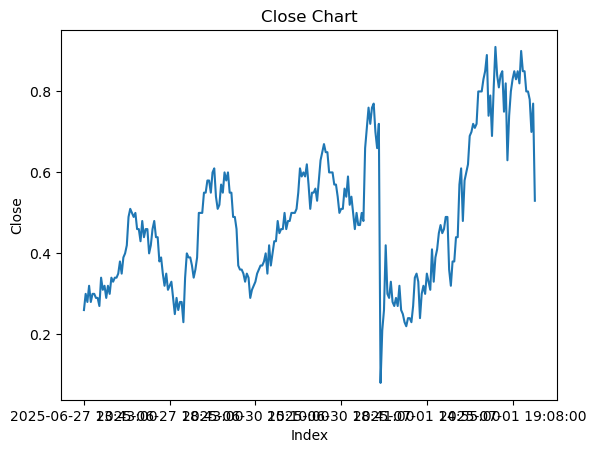

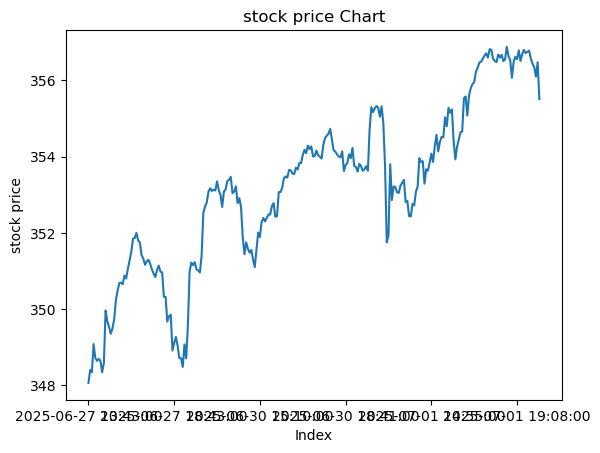

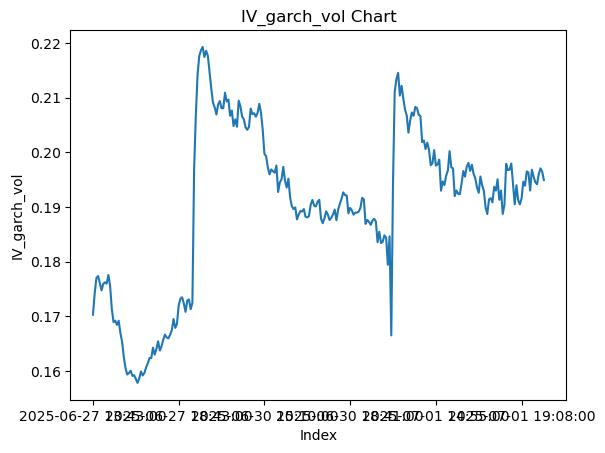

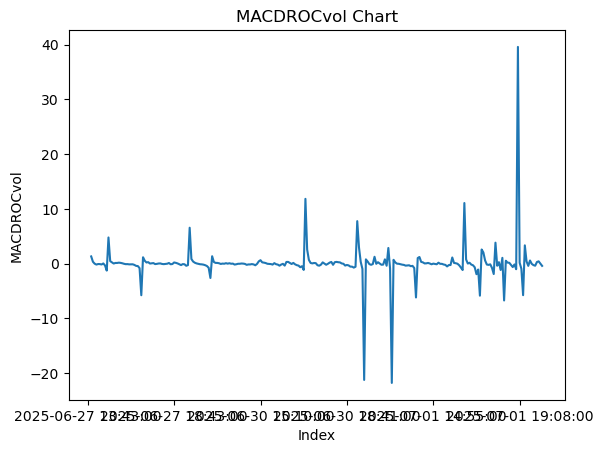

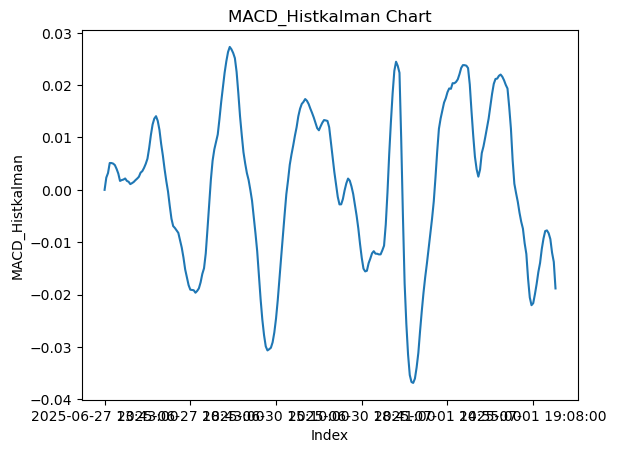

In [220]:
plot('Close')
plot('stock price')
plot('IV_garch_vol')
plot('MACDROCvol')
plot('MACD_Histkalman')

In [221]:
lag = 9 
# Precompute the rolling mean of Kalman_Roc (window=3)
datafix["Kalman_Roc_roll"] = datafix["Kalman_Roc"].rolling(lag).mean()
datafix["MACDROCvolroll9"] = datafix["MACDROCvol"].rolling(9).mean()
datafix["MACDROCkalroll9"] = datafix["MACDROCkal"].rolling(9).mean()

# assign other variables -- stocksma can be a screener filter along with volume and implied volatility 
datafix["stocktrend"] = datafix["stock price"].pct_change().rolling(3).mean()
datafix["sma30"] = datafix["Close"].rolling(20).mean()
datafix["smaspread"] = datafix["sma30"] - datafix["Close"] 
# no MACDs 
datafix["IV_garch_volsma"] = datafix['IV_garch_vol'].pct_change().rolling(18).mean()
datafix["kalmansma"] = datafix['Kalman'].pct_change().rolling(5).mean()
datafix["Closelag"] = datafix["Close"].shift(1)
datafix["Stocklag"] = datafix["stock price"].shift(1)

In [222]:
## BUY random Forest 
lookahead = 30  # Number of bars to look ahead for the price increase
threshold = 0.40  # 40% increase

# Shifted array of future max closes
future_max_close = datafix['Close'].shift(-1).rolling(window=lookahead, min_periods=1).max()

# Calculate percent increase from current close to future max close
pct_increase = (future_max_close - datafix['Close']) / datafix['Close']

# Label as 1 if increase > 40%, else 0
datafix['BuyLabel'] = (pct_increase > threshold).astype(int)

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Calculate rolling averages for features
datafix["VolumeSMA9"] = datafix["Volume"].rolling(9).mean()
datafix["VolumeSMA26"] = datafix["Volume"].rolling(26).mean()

# Define features based on your strategy
features = [
    "kalmansma",
    "IV_garch_volsma",
    "VolumeSMA9",
    "VolumeSMA26",
    "Closelag",
    "Stocklag"
]


# Drop rows with missing values in features or label
model_data = datafix.dropna(subset=features + ["BuyLabel"])

X = model_data[features]
y = model_data["BuyLabel"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.6)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict signals
model_data["Predicted_Signal"] = rf.predict(X)

# You can now use model_data["Predicted_Signal"] for your trading logic
# Assuming you have a trained model called 'rf' and features list
datafix["Predicted_Signal"] = rf.predict(datafix[features])


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_8139/1458611917.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["Predicted_Signal"] = rf.predict(X)


In [223]:
# SELL random Forest
lookahead = 30  # Number of bars to look ahead for the price decrease
threshold = -0.40  # 40% decrease

# Shifted array of future min closes
future_min_close = datafix['Close'].shift(-1).rolling(window=lookahead, min_periods=1).min()

# Calculate percent decrease from current close to future min close
pct_decrease = (future_min_close - datafix['Close']) / datafix['Close']

# Label as 1 if decrease < -40%, else 0
datafix['SellLabel'] = (pct_decrease < threshold).astype(int)
# Drop rows with missing values in features or label
model_data_sell = datafix.dropna(subset=features + ["SellLabel"])

X_sell = model_data_sell[features]
y_sell = model_data_sell["SellLabel"]

X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(
    X_sell, y_sell, shuffle=False, test_size=0.6
)

rf_sell = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sell.fit(X_train_sell, y_train_sell)

# Predict signals
model_data_sell["Predicted_Sell"] = rf_sell.predict(X_sell)
datafix["Predicted_Sell"] = rf_sell.predict(datafix[features])


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_8139/3215423051.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_sell["Predicted_Sell"] = rf_sell.predict(X_sell)


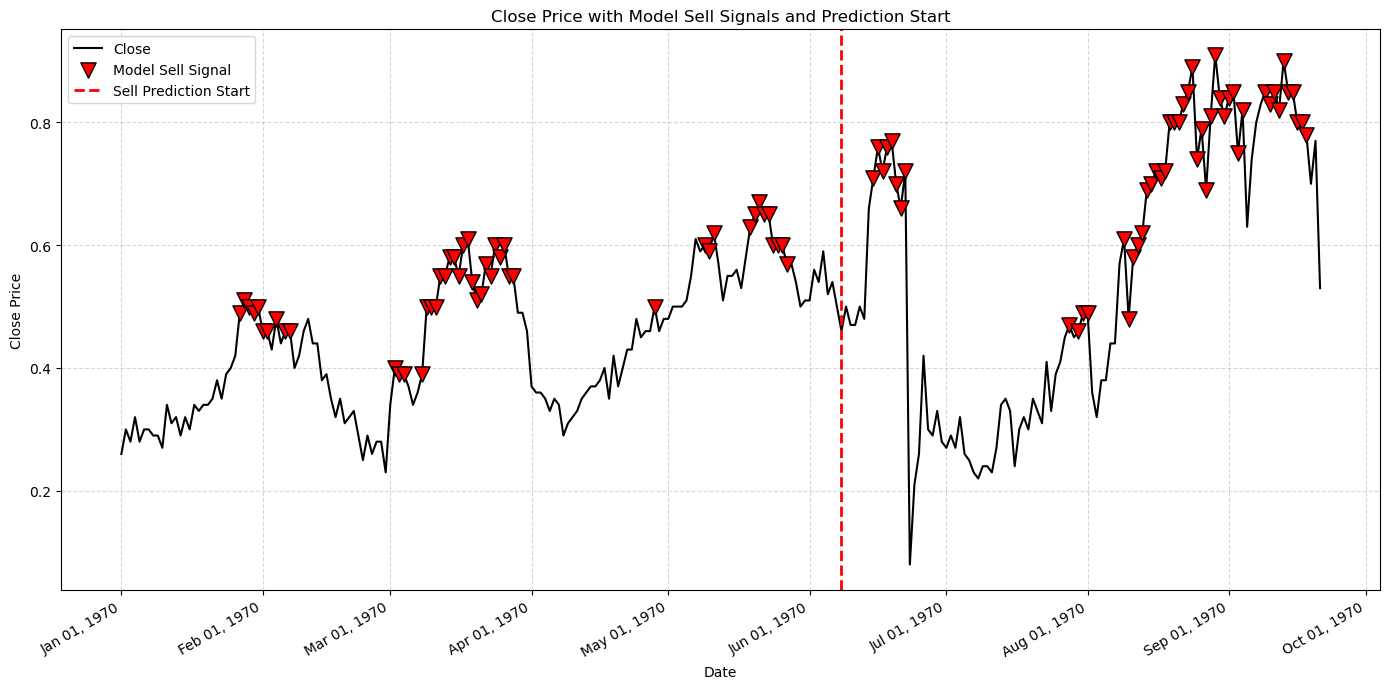

In [224]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))

# Plot the close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# Plot all model sell signals as red downward triangles
sell_signals = datafix[datafix["Predicted_Sell"] == 1]
plt.scatter(
    sell_signals.index,
    sell_signals["Close"],
    marker="v",
    color="red",
    edgecolor="black",
    s=120,
    label="Model Sell Signal",
    zorder=3
)

# Find the index where sell predictions begin (start of test set)
split_idx_sell = int(len(datafix) * 0.6)  # 40% train, 60% test as in your code
split_date_sell = datafix.index[split_idx_sell]

# Draw a vertical line at the prediction start
plt.axvline(x=split_date_sell, color='red', linestyle='--', linewidth=2, label='Sell Prediction Start')

plt.title("Close Price with Model Sell Signals and Prediction Start")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

# Use automatic date formatting for clarity
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


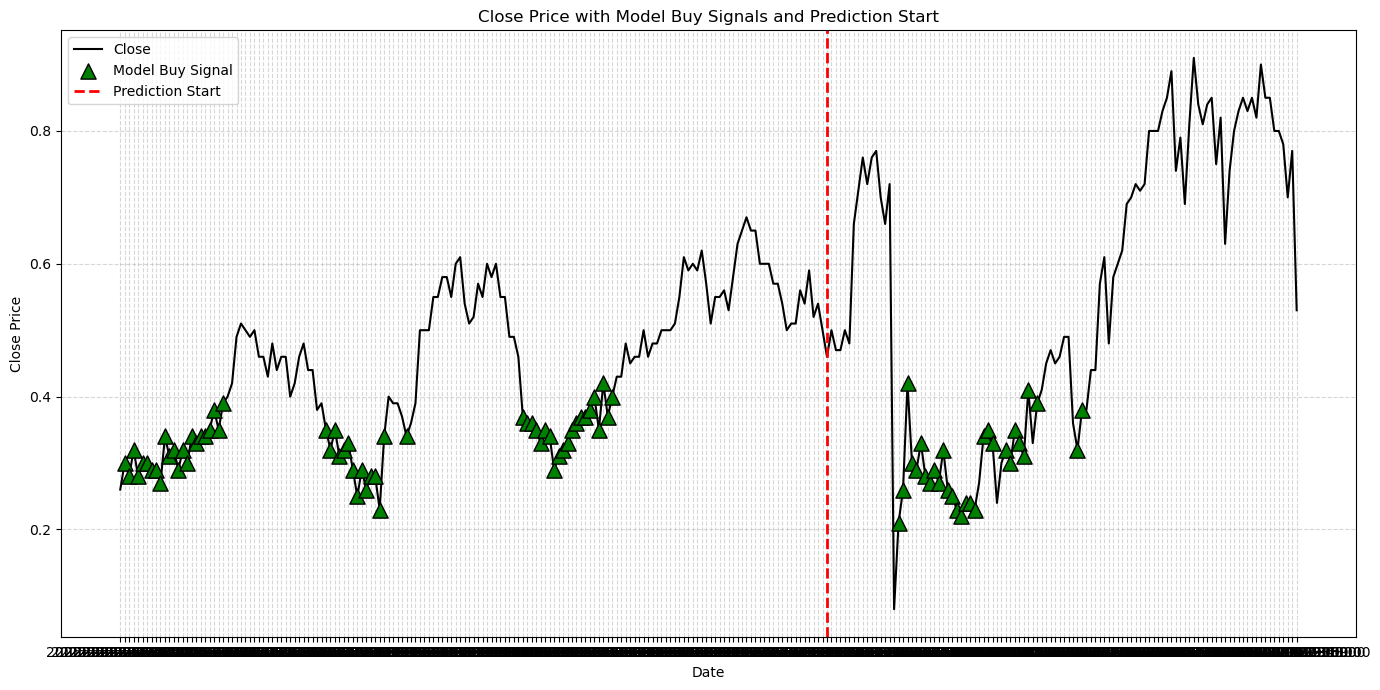

In [225]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.figure(figsize=(14, 7))

# Plot the close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# Plot all model buy signals as green upward triangles
buy_signals = datafix[datafix["Predicted_Signal"] == 1]
plt.scatter(
    buy_signals.index,
    buy_signals["Close"],
    marker="^",
    color="green",
    edgecolor="black",
    s=120,
    label="Model Buy Signal",
    zorder=3
)

# Find the index where predictions begin (start of test set)
split_idx = int(len(datafix) * 0.6)  # 80% train, 20% test
split_date = datafix.index[split_idx]

# Draw a vertical line at the prediction start
plt.axvline(x=split_date, color='red', linestyle='--', linewidth=2, label='Prediction Start')

plt.title("Close Price with Model Buy Signals and Prediction Start")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

# Use automatic date formatting for clarity

plt.tight_layout()
plt.show()


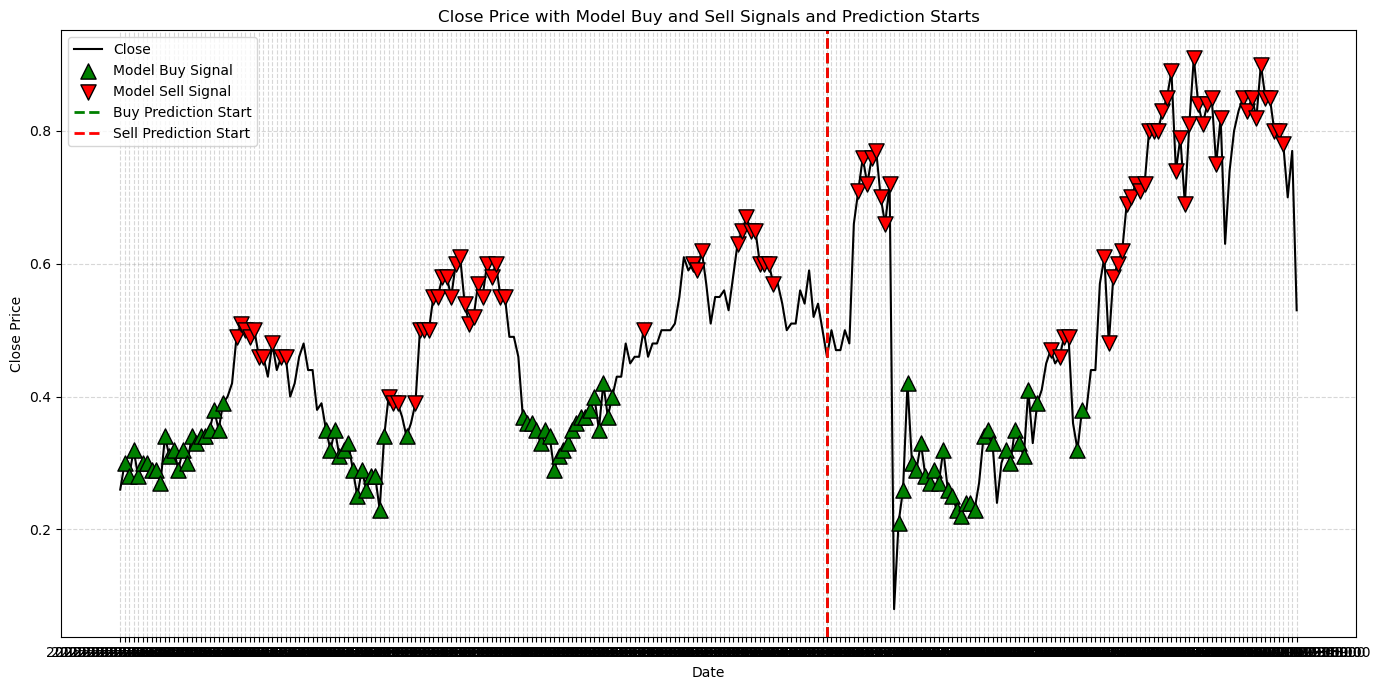

In [226]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.figure(figsize=(14, 7))

# Plot the close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# Plot buy signals (green upward triangle)
buy_signals = datafix[datafix["Predicted_Signal"] == 1]
plt.scatter(
    buy_signals.index,
    buy_signals["Close"],
    marker="^",
    color="green",
    edgecolor="black",
    s=120,
    label="Model Buy Signal",
    zorder=3
)

# Plot sell signals (red downward triangle)
sell_signals = datafix[datafix["Predicted_Sell"] == 1]
plt.scatter(
    sell_signals.index,
    sell_signals["Close"],
    marker="v",
    color="red",
    edgecolor="black",
    s=120,
    label="Model Sell Signal",
    zorder=3
)

# Draw vertical lines where out-of-sample predictions begin
# For buy model (adjust split as per your test_size)
split_idx_buy = int(len(datafix) * 0.6)  # 40% train, 60% test as in your code above
split_date_buy = datafix.index[split_idx_buy]
plt.axvline(x=split_date_buy, color='green', linestyle='--', linewidth=2, label='Buy Prediction Start')

# For sell model (assuming same split, otherwise adjust accordingly)
split_idx_sell = int(len(datafix) * 0.6)
split_date_sell = datafix.index[split_idx_sell]
plt.axvline(x=split_date_sell, color='red', linestyle='--', linewidth=2, label='Sell Prediction Start')

plt.title("Close Price with Model Buy and Sell Signals and Prediction Starts")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)


plt.tight_layout()
plt.show()


In [227]:
# Get probabilities (assuming binary classification, class 1 is buy/sell)
datafix["Buy_Prob"] = rf.predict_proba(datafix[features])[:, 1]
datafix["Sell_Prob"] = rf_sell.predict_proba(datafix[features])[:, 1]

# Weighted difference (you can adjust the weights)
datafix["Combined_Score"] = datafix["Buy_Prob"] - datafix["Sell_Prob"]

# Define thresholds for action
def weighted_signal(score, buy_thresh=0.70, sell_thresh=-0.70):
    if score > buy_thresh:
        return "buy"
    elif score < sell_thresh:
        return "sell"
    else:
        return "hold"

datafix["Combined_Signal"] = datafix["Combined_Score"].apply(weighted_signal)


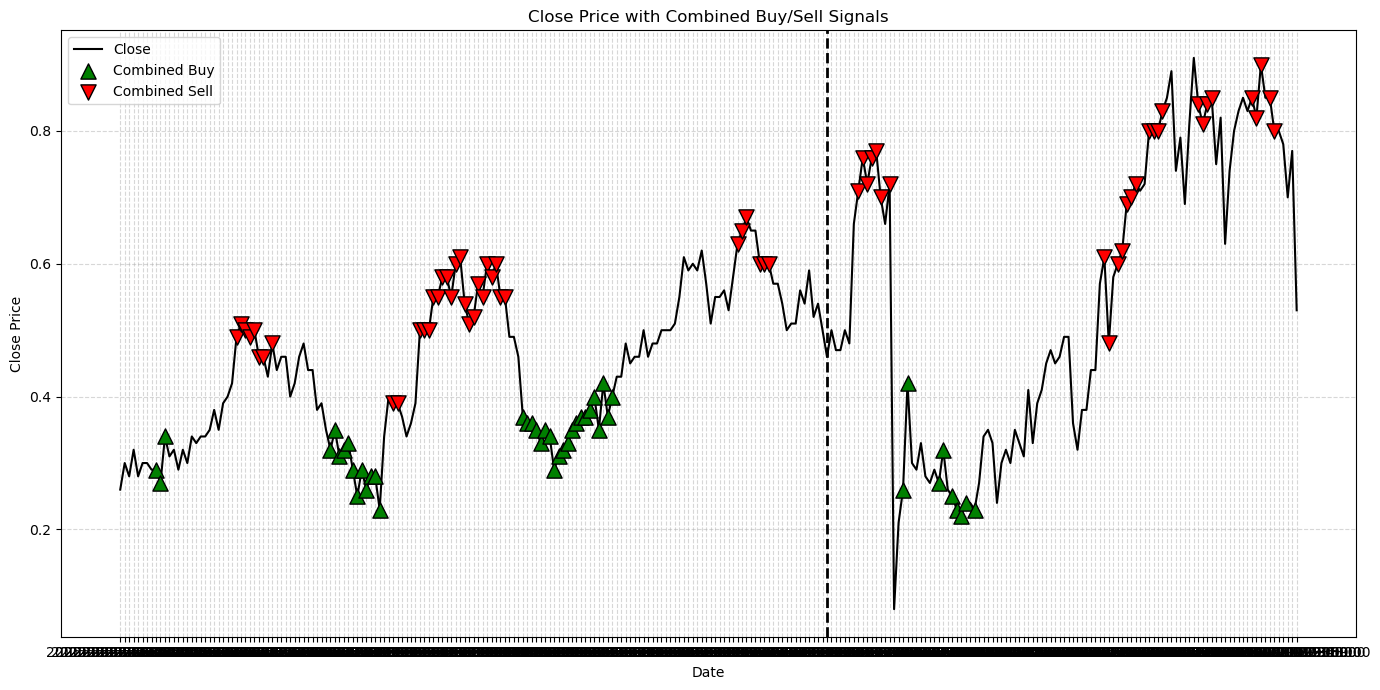

In [228]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))

# Plot the close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# Plot combined buy signals (green upward triangle)
buy_signals = datafix[datafix["Combined_Signal"] == "buy"]
plt.scatter(
    buy_signals.index,
    buy_signals["Close"],
    marker="^",
    color="green",
    edgecolor="black",
    s=120,
    label="Combined Buy",
    zorder=3
)

# Plot combined sell signals (red downward triangle)
sell_signals = datafix[datafix["Combined_Signal"] == "sell"]
plt.scatter(
    sell_signals.index,
    sell_signals["Close"],
    marker="v",
    color="red",
    edgecolor="black",
    s=120,
    label="Combined Sell",
    zorder=3
)

plt.title("Close Price with Combined Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

# For sell model (assuming same split, otherwise adjust accordingly)
split_idx_bar = int(len(datafix) * 0.6)
split_date_bar = datafix.index[split_idx_bar]
plt.axvline(x=split_date_bar, color='black', linestyle='--', linewidth=2, label=' Prediction Start')

plt.tight_layout()
plt.show()


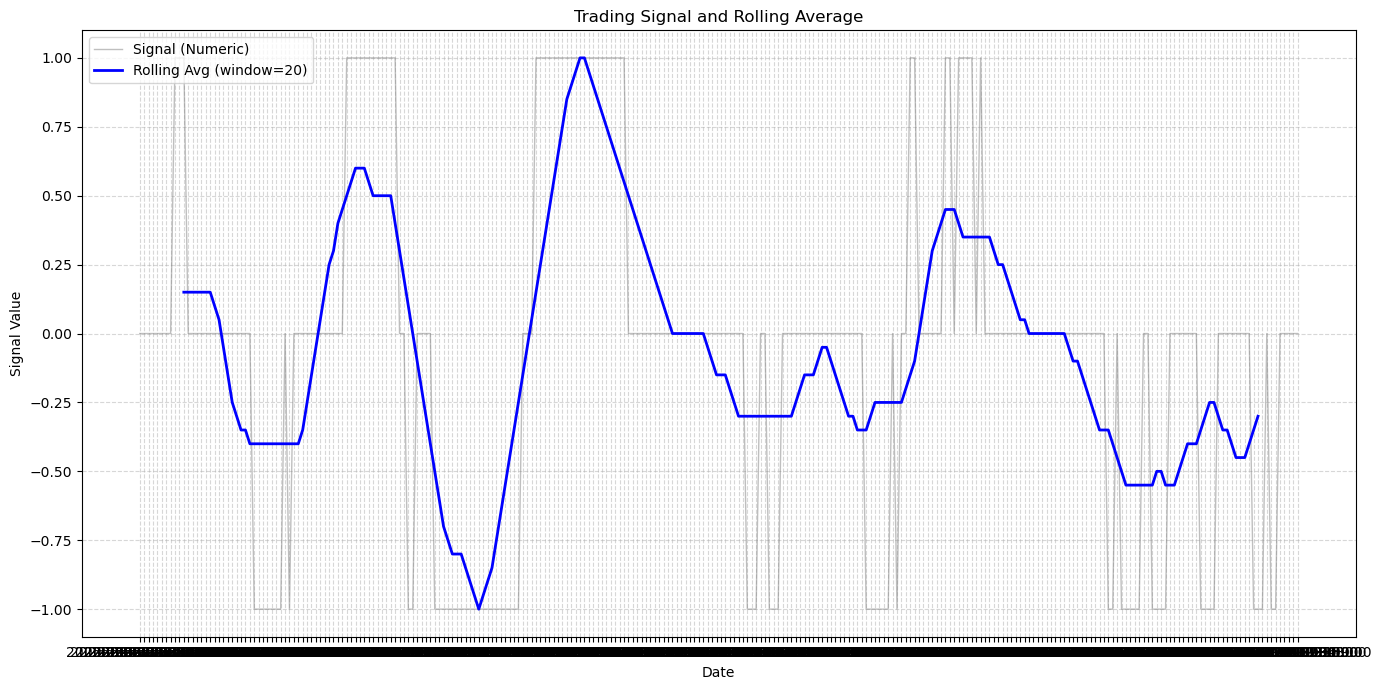

In [229]:
# Map signals to numeric: buy=1, sell=-1, hold=0 (example)
signal_map = {"buy": 1, "sell": -1, "hold": 0}
datafix["Signal_Num"] = datafix["Combined_Signal"].map(signal_map)

# Rolling average
datafix["Rolling_Signal_Num"] = datafix["Signal_Num"].rolling(window=20, center=True).mean()

# Plot similarly as above
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))

# Plot the numeric signal (buy=1, sell=-1, hold=0)
plt.plot(datafix.index, datafix["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)

# Plot the rolling average of the signal
plt.plot(
    datafix.index,
    datafix["Rolling_Signal_Num"],
    label=f"Rolling Avg (window={20})",
    color="blue",
    linewidth=2
)

plt.title("Trading Signal and Rolling Average")
plt.xlabel("Date")
plt.ylabel("Signal Value")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


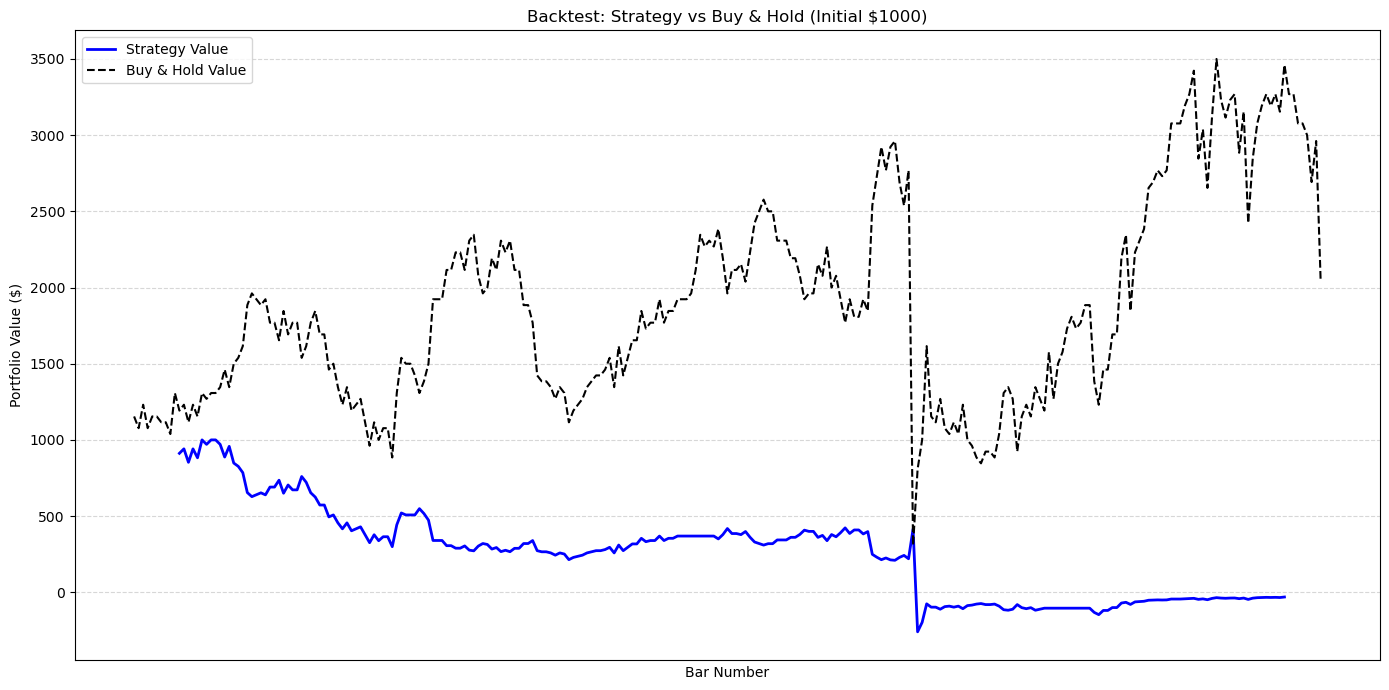

In [230]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate daily returns
datafix["Return"] = datafix["Close"].pct_change()

# Generate position: 1 for long, -1 for short, 0 for flat
datafix["Position"] = np.sign(datafix["Rolling_Signal_Num"]).shift(1)

# Calculate strategy returns
datafix["Strategy_Return"] = datafix["Position"] * datafix["Return"]

# Calculate cumulative returns, starting from 1000
datafix["Cumulative_Strategy_Value"] = 1000 * (1 + datafix["Strategy_Return"]).cumprod()
datafix["Cumulative_BuyHold_Value"] = 1000 * (1 + datafix["Return"]).cumprod()

# Plot using integer index, remove date axis
plt.figure(figsize=(14,7))
plt.plot(datafix.index, datafix["Cumulative_Strategy_Value"], label="Strategy Value", color="blue", linewidth=2)
plt.plot(datafix.index, datafix["Cumulative_BuyHold_Value"], label="Buy & Hold Value", color="black", linestyle="--")

plt.title("Backtest: Strategy vs Buy & Hold (Initial $1000)")
plt.xlabel("Bar Number")
plt.ylabel("Portfolio Value ($)")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

# Remove x-axis tick labels for a clean look
plt.xticks([])  # or plt.gca().set_xticklabels([]) for more control[3][4]

plt.tight_layout()
plt.show()
